# 1. Imports

In [1]:
# Import packages
import numpy as np
import pandas as pd

from sklearn.isotonic import IsotonicRegression
from scipy.stats import norm, gamma
from scipy import interpolate, optimize, integrate

import matplotlib.pyplot as plt
import seaborn as sns

import copy
import random
import itertools
import time

from W_Stress import W_Stress
from helper import create_u_grid

In [2]:
# Set random seed
np.random.seed(1)

# 2. Generating Data - The Baseline Model

In [3]:
def generate_spatial_data(Nsims, plot=True):
    # Get z1, ... , z10 where zi = (zi(1), zi(2)) and zi(1), zi(2) ~ U(0,1)
    z1 = np.random.uniform(size=10)
    z2 = np.random.uniform(size=10)
    z = list(zip(z1, z2))

    # Get theta in (0, 0.4, 5) with probabilities (0.05, 0.6, 0.35)
    x = np.random.uniform(0, 1, size=Nsims)
    thetas = np.zeros(Nsims)

    thetas[np.where(x <= 0.05)] = 0
    thetas[np.where((0.05 < x) & (x <= 0.65))] = 0.4
    thetas[np.where(x > 0.65)] = 5

    # Generate realizations of (L1, ..., L10) using Gaussian copulas
    x = np.zeros((Nsims, 10))
    theta_labels = {5:[], 0.4:[], 0: []}
    for i in range(Nsims):
        theta = thetas[i]
        # Get the correlation
        # rho_ij = exp{-theta_i * ||zi - zj||} where ||.|| denotes the Euclidean distance
        Omega = np.zeros((10, 10))
        for j in range(10):
            for k in range(10):
                Omega[j, k] = np.exp(-theta * np.linalg.norm(np.array(z[j]) - np.array(z[k])))

        # Create samples from a correlated multivariate normal
        x0 = np.random.multivariate_normal(mean=np.zeros(10), cov=Omega)
        x[i, :] = x0
        theta_labels[theta].append(i)

    # Get uniform marginals
    u = norm.cdf(x)

    # Marginal distributions Li ~ Gamma(5, 0.2i) with mean=25
    L = np.zeros((Nsims, 10))
    x_axis = np.linspace(25, 50, 200)
    means = np.zeros(10)
    for i in range(10):
        L_i = gamma.ppf(u[:, i], a=5, loc=25, scale=0.2*(i+1))
        L[:, i] = L_i

        means[i] = np.mean(L_i)

        # Gamma distribution plot
        if plot:
            y_i = gamma.pdf(x_axis, a=5, loc=25, scale=0.2*(i+1))
            plt.plot(x_axis, y_i, label=f"scale={0.2*(i+1)}")
    if plot:
        plt.legend()
        plt.savefig('Plots/ex/data_marginal_dist.pdf', format='pdf')
        plt.show()

    max_mean = np.max(means)
    min_mean = np.min(means)
    marker_sizes = (means - min_mean)/(max_mean - min_mean)*150

    # Location plot
    if plot:
        plt.scatter(z1, z2, marker='o', color='black', s=marker_sizes)
        plt.savefig('Plots/ex/data_location_by_mean.pdf', format='pdf')
        plt.show()

    # Define the data and get the bandwidths, density and CDF
    data = {"y": np.sum(L, axis=1), "x": L}

    return data, theta_labels

# 3. Calculating Stressed Models

### 3a. Setup the W_Stress Model

In [4]:
# Define the gridspace
u = create_u_grid([0.005, 0.95])

# Generate data (spatial)
data, theta_labels = generate_spatial_data(1000, plot=False)
brackets = [200, 450]
folder = 'Plots/ex/'

In [5]:
# Generate the model
StressModel = W_Stress(data, u, brackets)

### 3b. Example: Stress ES risk measure

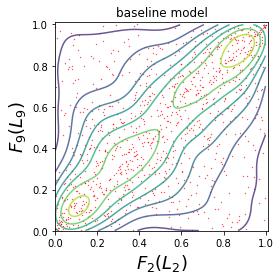

lambda =  [-0.24073224  0.23842413]
 WD =  0.9215453350893307
 Risk Measure =  [335.80198801 360.15807309]
 Target Risk Measure =  [335.8019831  360.15808064]
 Base Risk Measure =  [335.8019831  356.59215905]




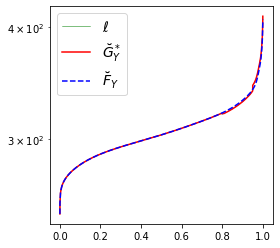

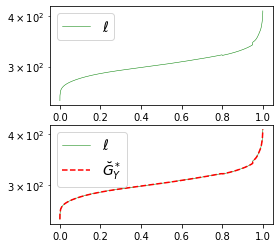

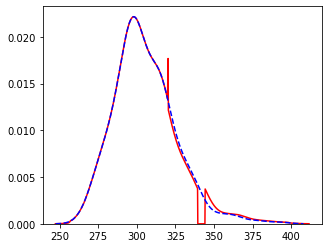

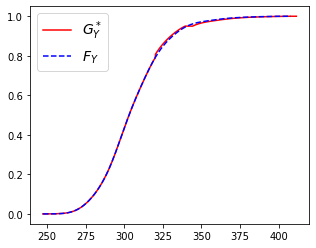

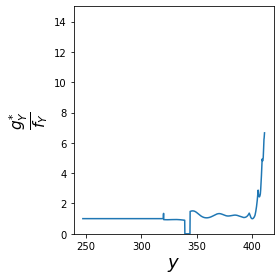

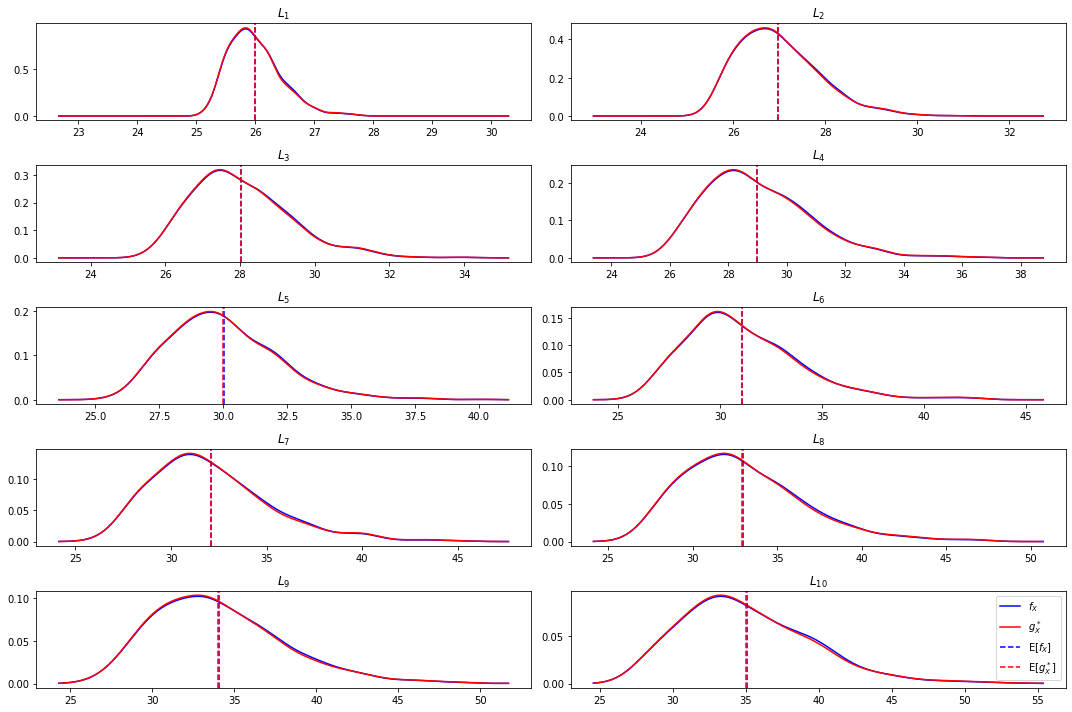

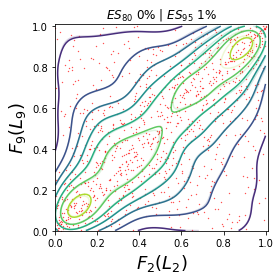

lambda =  [3.28912947 0.06927949]
 WD =  7.5139914265128205
 Risk Measure =  [352.59209149 374.4217769 ]
 Target Risk Measure =  [352.59208225 374.42176701]
 Base Risk Measure =  [335.8019831  356.59215905]




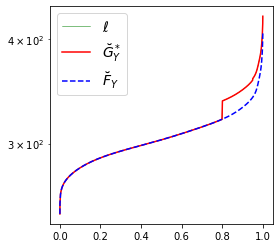

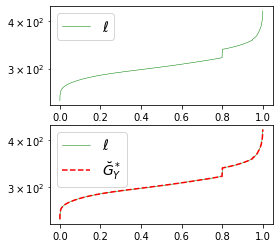

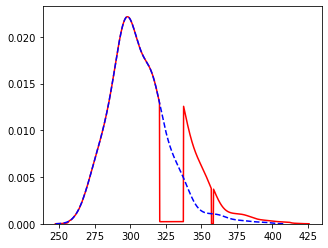

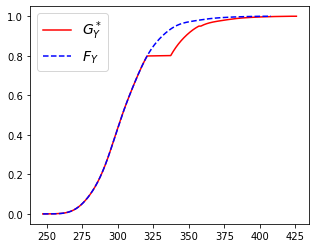

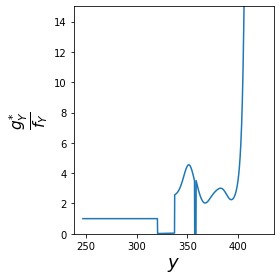

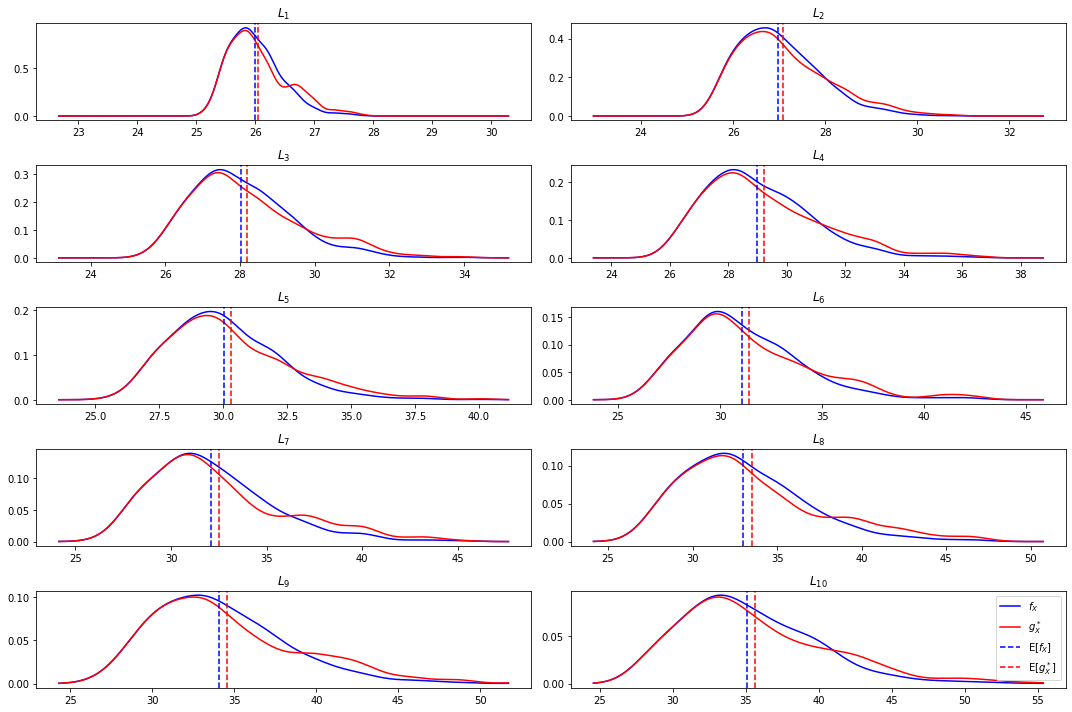

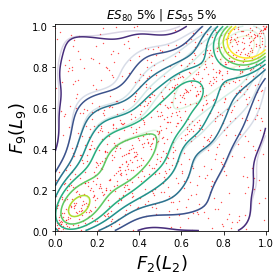

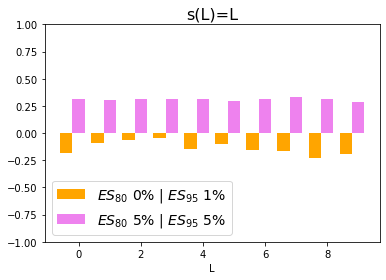

In [6]:
# Set alpha, gammas
alpha = [0.8, 0.95]
gammas = [lambda u: (u > alpha[0]) / (1 - alpha[0]), lambda u: (u > alpha[1]) / (1 - alpha[1])]
StressModel.set_gamma(gammas)

# Set stresses
ES_stresses = [[0, 1], [5, 5]]

# Set (Li, Lj) to plot
i = 1
j = 8

# Initialize sensitivity results lists
sensitivity_measures = []
labels = []
colors = ['orange', 'violet']

# Run optimization
# Get baseline risk measure to be stressed
RM_P = StressModel.get_risk_measure_baseline()

# Plot baseline copulas for selected (Li, Lj)
StressModel.plot_copula_baseline(i, j, folder + f'hara-es/copula/data', save=False)

# Run each stress
for stress in ES_stresses:
    lam, WD, RM_Q, fig = StressModel.optimise_rm(RM_P * np.array([1 + stress[0]/100, 1 + stress[1]/100]))
    
    # Generate filename
    filename = folder + f'ES/data_ES_80_{stress[0]}_95_{stress[1]}'
#     fig.savefig(filename + '_inv.pdf',format='pdf')

    # Plot result distributions
    StressModel.plot_dist(filename, type="ES", save=False)

    # Plot density of Li
    StressModel.plot_xdensity(filename, save=False)

    # Plot copula contours for selected (Li, Lj)
    StressModel.plot_copula(i, j, folder + f'ES/copula/data_ES_{stress[0]}_{stress[1]}',
                            save=False, title=f'$ES_{{80}}$ {stress[0]}% | $ES_{{95}}$ {stress[1]}%')


    # Calculate sensitivity_measures
    sensitivity_measures.append(StressModel.reverse_sensitivity_measure(lambda x: x, StressModel.data['x']))
    labels.append(f'$ES_{{80}}$ {stress[0]}% | $ES_{{95}}$ {stress[1]}%')

# Plot sensitivities
StressModel.plot_sensitivities(sensitivity_measures,
folder + f'ES/data_ES_80_95_sensitivity.pdf', colors, labels, title='s(L)=L', save=False)

### 3c. Example: Stress HARA utility + ES risk measure

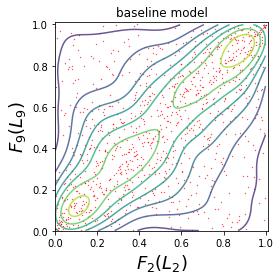

lambda =  [ 0.28728737 -0.24302816  0.23846474]
 WD =  0.921608112796659
 RM, Utility =  [335.8019831  360.15808065] 24.79541486654383
 Targets =  [335.8019831  360.15808064] 24.79541486553255
 Base =  [335.8019831  356.59215905] 24.79541486553255




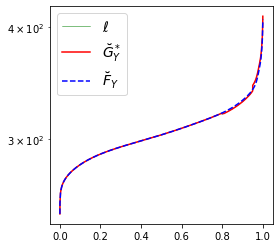

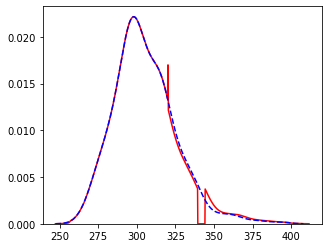

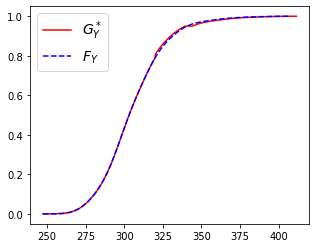

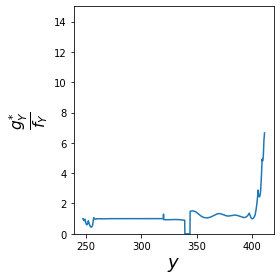

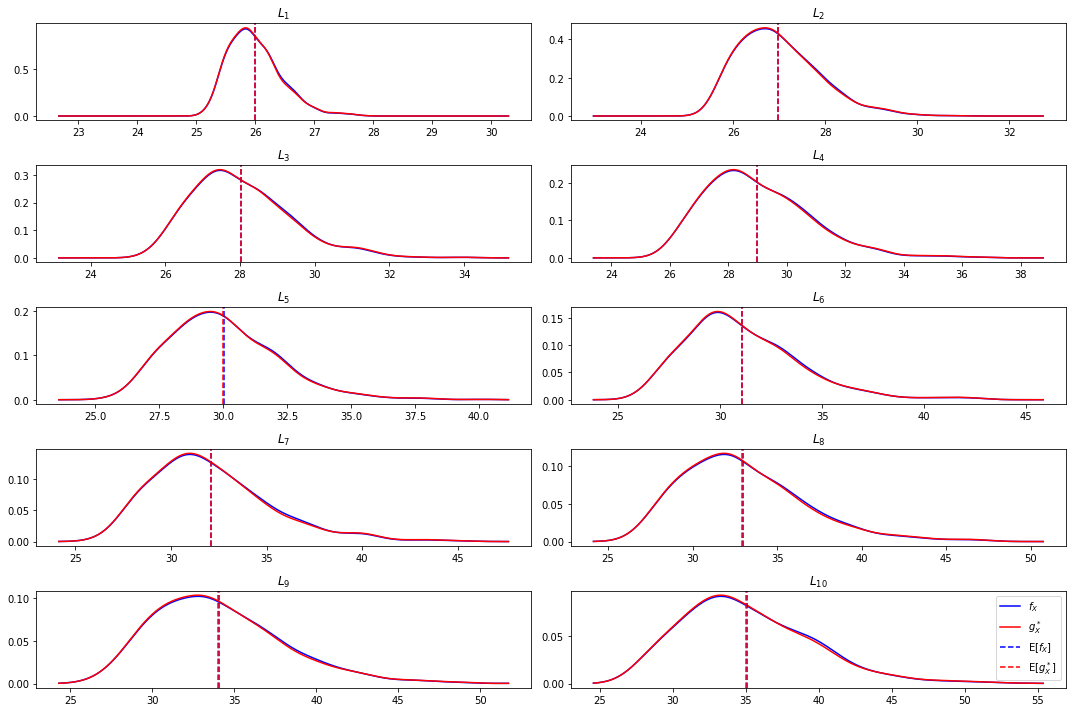

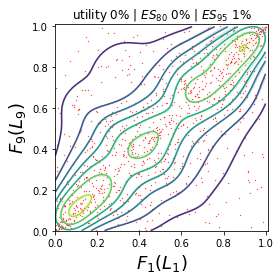

lambda =  [171.48038094  -1.22786531   0.52626811]
 WD =  6.607664841974908
 RM, Utility =  [339.16000295 367.28992418] 25.043369495242818
 Targets =  [339.16000293 367.28992382] 25.043369014187874
 Base =  [335.8019831  356.59215905] 24.79541486553255




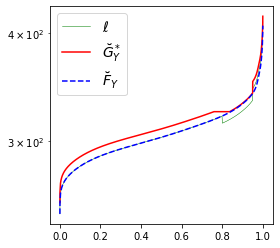

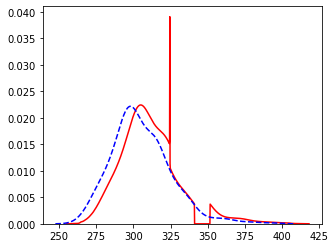

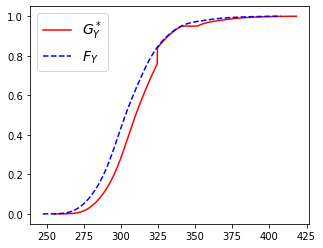

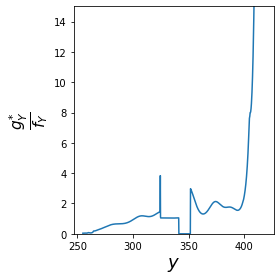

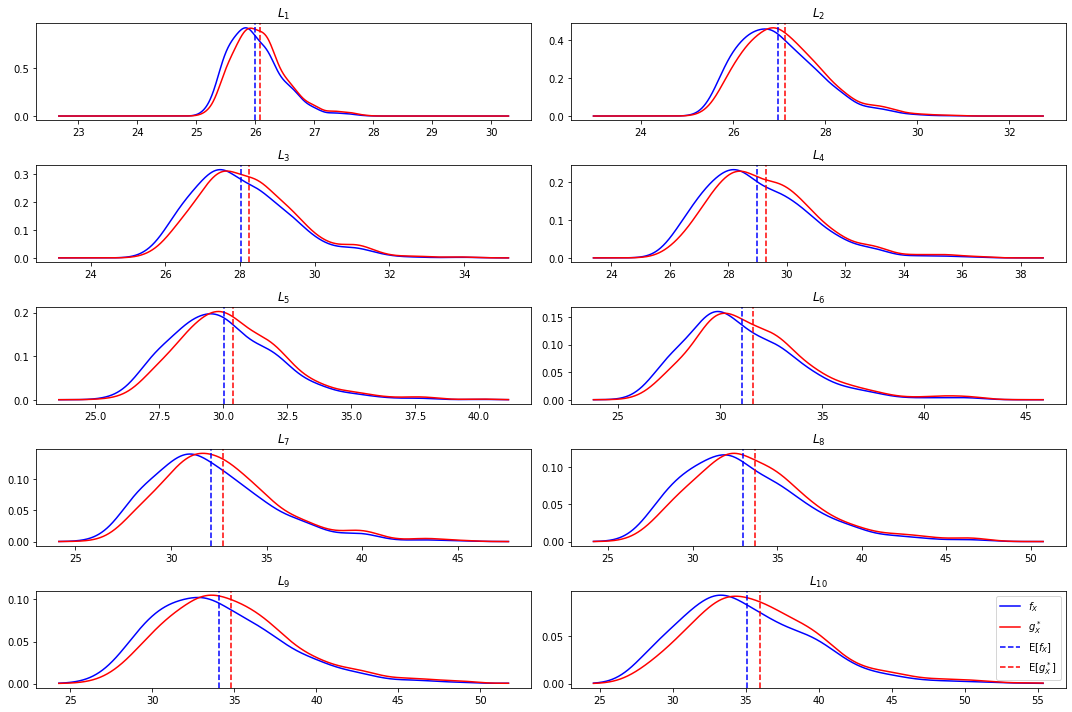

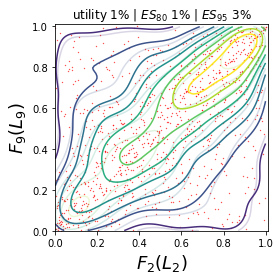

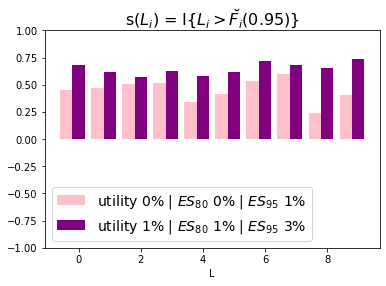

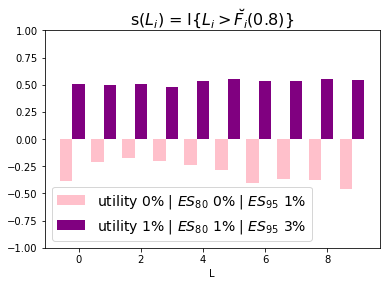

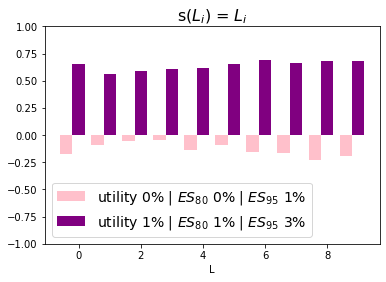

In [7]:
# Define hara parameters
a = 1
eta = 0.5
hara = lambda a, b, eta, x: (1 - eta) / eta * (a * x / (1 - eta) + b) ** eta
b = lambda eta: 5 * (eta / (1 - eta)) ** (1 / eta)

# Set alpha, gammas
alpha = [0.8, 0.95]
gammas = [lambda u: (u > alpha[0]) / (1 - alpha[0]), lambda u: (u > alpha[1]) / (1 - alpha[1])]
StressModel.set_gamma(gammas)

# Set stresses
utility_stresses = [0, 1]
rm_stresses = [[0, 1], [1, 3]]

# Set (Li, Lj) to plot
i = 1
j = 8

# Initialize sensitivity results lists
sensitivity_measures1 = []
sensitivity_measures2 = []
sensitivity_measures3 = []
labels = []
colors = ['pink', 'purple', 'blue']

# Run optimization
# Get baseline risk measure and utility to be stressed
RM_P = StressModel.get_risk_measure_baseline()
Utility_P = StressModel.get_hara_utility(a, b(eta), eta, StressModel.u, StressModel.F_inv)

# Plot baseline copulas for selected (Li, Lj)
StressModel.plot_copula_baseline(i, j, folder + f'hara-es/copula/data', save=False)

# Run each stress
for i in range(len(utility_stresses)):
    utility_stress = utility_stresses[i]
    rm_stress = rm_stresses[i]

    _, _, _, fig = StressModel.optimise_HARA(a, b(eta), eta, Utility_P * (1 + utility_stress / 100),
                                             RM_P * np.array([1 + rm_stress[0] / 100, 1 + rm_stress[1] / 100]))

    # Generate filename
    filename = folder + f'hara-es/data_utility_{utility_stress}_ES_{rm_stress[0]}_{rm_stress[1]}'
    # fig.savefig(filename + '_inv.pdf', format='pdf')

    # Plot result distributions
    StressModel.plot_dist(filename, type="Utility", save=False)
    
    # Plot density of Li
    StressModel.plot_xdensity(filename, save=False)

    # Plot copula contours for selected (Li, Lj)
    StressModel.plot_copula(i, j, folder + f'hara-es/copula/data_utility_{utility_stress}_ES_{rm_stress[0]}_{rm_stress[1]}',
                            save=False, title=f'utility {utility_stress}% | $ES_{{80}}$ {rm_stress[0]}% | $ES_{{95}}$ {rm_stress[1]}%')

    # Calculate sensitivity_measures
    S1 = np.zeros(10)
    S2 = np.zeros(10)
    for k in range(10):
        # Get s:R->R
        level1 = 0.95
        level2 = 0.8
        s1 = lambda x: x > gamma.ppf(level1, a=5, loc=25, scale=0.2 * (k + 1))
        s2 = lambda x: x > gamma.ppf(level2, a=5, loc=25, scale=0.2 * (k + 1))
        S1[k] = StressModel.reverse_sensitivity_measure(s1, StressModel.data['x'][:, k])
        S2[k] = StressModel.reverse_sensitivity_measure(s2, StressModel.data['x'][:, k])
    S3 = StressModel.reverse_sensitivity_measure(lambda x: x, StressModel.data['x'])

    sensitivity_measures1.append(S1)
    sensitivity_measures2.append(S2)
    sensitivity_measures3.append(S3)

    labels.append(f'utility {utility_stress}% | $ES_{{80}}$ {rm_stress[0]}% | $ES_{{95}}$ {rm_stress[1]}%')

# Plot sensitivities
StressModel.plot_sensitivities(sensitivity_measures1, labels=labels, colors=colors,
                           title=r's($L_i$) = I{$L_i > \breve{F_i}(0.95)$}', save=False,
                           filename=f'Plots/ex/hara-es/data_ES_utility_sensitivity_95.pdf')
StressModel.plot_sensitivities(sensitivity_measures2, labels=labels, colors=colors,
                           title=r's($L_i$) = I{$L_i > \breve{F_i}(0.8)$}', save=False,
                           filename=f'Plots/ex/hara-es/data_ES_utility_sensitivity_80.pdf')
StressModel.plot_sensitivities(sensitivity_measures3, labels=labels, colors=colors,
                           title=r's($L_i$) = $L_i$', save=False,
                           filename=folder + f'hara-es/data_ES_utility_sensitivity.pdf')